# <center>Tutorial-5</center>
## <center>Transductive vs Inductive Learning on GNNs for Node Classification</center>

## Table of Contents
1. Introduction
2. Setup and Data Loading
3. Understanding Inductive vs Transductive Learning
4. Model Implementations

      4.1 Graph Convolutional Network (GCN)
      
      4.2 GraphSAGE
5. Training and Evaluation
6. Results and Visualizations

## 1. Introduction

In this tutorial, we'll implement and compare three popular Graph Neural Network (GNN) architectures:
- Graph Convolutional Network (GCN)
- GraphSAGE

We'll use the Protein-Protein Interaction (PPI) dataset, which is a multi-label node classification task. This dataset is particularly interesting because it requires inductive learning, allowing us to highlight the differences between inductive and transductive approaches.

## 2. Setup and Data Loading

First, let's import the necessary libraries and load the PPI dataset.

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load PPI dataset
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

num_features = train_dataset.num_features
num_classes = train_dataset.num_classes

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")


Number of training graphs: 20
Number of validation graphs: 2
Number of test graphs: 2
Number of features: 50
Number of classes: 121


## 3. Understanding Inductive vs Transductive Learning

Before we implement the models, let's discuss the key differences between inductive and transductive learning in the context of GNNs.

<img title="Tranductive Vs. Inductive" alt="Alt text" src="tvsi.png">

### Transductive Learning:
- The entire graph (including test nodes) is available during training.
- The model learns to make predictions for specific nodes in a single, fixed graph.
- Cannot generalize to unseen nodes or graphs.
- Typical for tasks on a single, large graph (e.g., citation networks).

### Inductive Learning:
- The model learns to generalize to unseen nodes or entirely new graphs.
- Training is done on a set of graphs, and testing is performed on different, unseen graphs.
- Can handle dynamic graphs and generalizes to new nodes/graphs.
- Suitable for tasks involving multiple graphs or where test nodes are not available during training.

The PPI dataset and inductive learning:
1. It consists of multiple graphs (24 for training, 2 for validation, 2 for testing).
2. The test graphs are completely separate from the training graphs.
3. The model must generalize to unseen proteins (nodes) in new cellular contexts (graphs).

This inductive nature of the PPI task influences our model design and training procedure, as we'll see in the following sections.

In [2]:
### 4.1 Graph Convolutional Network (GCN)


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.conv3(x, edge_index)



### 4.2 GraphSAGE


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.conv3(x, edge_index)


Note that all three models have a similar structure with three layers. This design allows them to capture multi-hop neighborhood information, which is crucial for the PPI task. The main differences lie in how they process and aggregate neighborhood information:

- GCN uses a simple neighborhood averaging approach.
- GraphSAGE uses a sample and aggregate approach, which is particularly suitable for inductive tasks.

In [3]:
## 5. Training and Evaluation

'''Now, let's define our training and evaluation procedures.'''

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.dataset)

def test(model, loader):
    model.eval()
    ys, preds = [], []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index)
        pred = (out > 0).float().cpu()
        y = data.y.cpu()
        ys.append(y)
        preds.append(pred)
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

def train_and_evaluate(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs=100):
    best_val_f1 = 0
    train_losses, val_f1s, test_f1s = [], [], []
    training_time = 0
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        loss = train(model, train_loader, optimizer, criterion)
        epoch_time = time.time() - start_time
        training_time += epoch_time
        
        val_f1 = test(model, val_loader)
        test_f1 = test(model, test_loader)
        
        train_losses.append(loss)
        val_f1s.append(val_f1)
        test_f1s.append(test_f1)
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}, Time: {epoch_time:.2f}s')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_f1s, test_f1s, training_time

In [4]:
# Initialize models
gcn = GCN(num_features, 256, num_classes).to(device)
sage = GraphSAGE(num_features, 256, num_classes).to(device)

# Define optimizers and criterion
criterion = torch.nn.BCEWithLogitsLoss()
gcn_optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
sage_optimizer = torch.optim.Adam(sage.parameters(), lr=0.01)

In [5]:
# Train and evaluate models
print("Training GCN...")
gcn, gcn_losses, gcn_val_f1s, gcn_test_f1s, gcn_time = train_and_evaluate(gcn, train_loader, val_loader, test_loader, gcn_optimizer, criterion)


print("\nTraining GraphSAGE...")
sage, sage_losses, sage_val_f1s, sage_test_f1s, sage_time = train_and_evaluate(sage, train_loader, val_loader, test_loader, sage_optimizer, criterion)

Training GCN...
Epoch: 001, Loss: 0.6042, Val F1: 0.4180, Test F1: 0.4192, Time: 0.92s
Epoch: 002, Loss: 0.5794, Val F1: 0.4340, Test F1: 0.4353, Time: 0.33s
Epoch: 003, Loss: 0.5673, Val F1: 0.4763, Test F1: 0.4831, Time: 0.32s
Epoch: 004, Loss: 0.5538, Val F1: 0.4979, Test F1: 0.5079, Time: 0.31s
Epoch: 005, Loss: 0.5392, Val F1: 0.3914, Test F1: 0.4039, Time: 0.31s
Epoch: 006, Loss: 0.5329, Val F1: 0.4956, Test F1: 0.5075, Time: 0.32s
Epoch: 007, Loss: 0.5254, Val F1: 0.4941, Test F1: 0.5051, Time: 0.32s
Epoch: 008, Loss: 0.5184, Val F1: 0.4964, Test F1: 0.5044, Time: 0.33s
Epoch: 009, Loss: 0.5115, Val F1: 0.4706, Test F1: 0.4841, Time: 0.31s
Epoch: 010, Loss: 0.5110, Val F1: 0.4747, Test F1: 0.4848, Time: 0.31s
Epoch: 011, Loss: 0.5104, Val F1: 0.5348, Test F1: 0.5481, Time: 0.32s
Epoch: 012, Loss: 0.4988, Val F1: 0.5291, Test F1: 0.5404, Time: 0.32s
Epoch: 013, Loss: 0.4961, Val F1: 0.5301, Test F1: 0.5414, Time: 0.31s
Epoch: 014, Loss: 0.4916, Val F1: 0.5441, Test F1: 0.5573, Ti

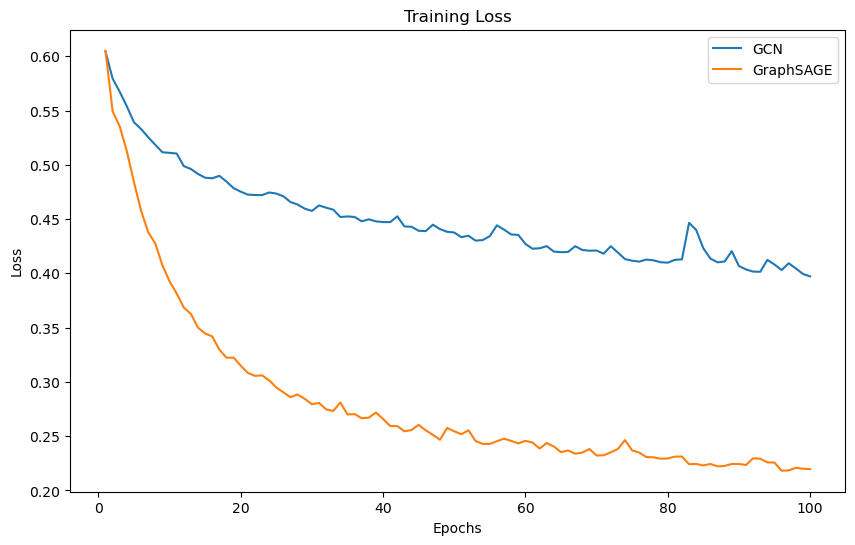

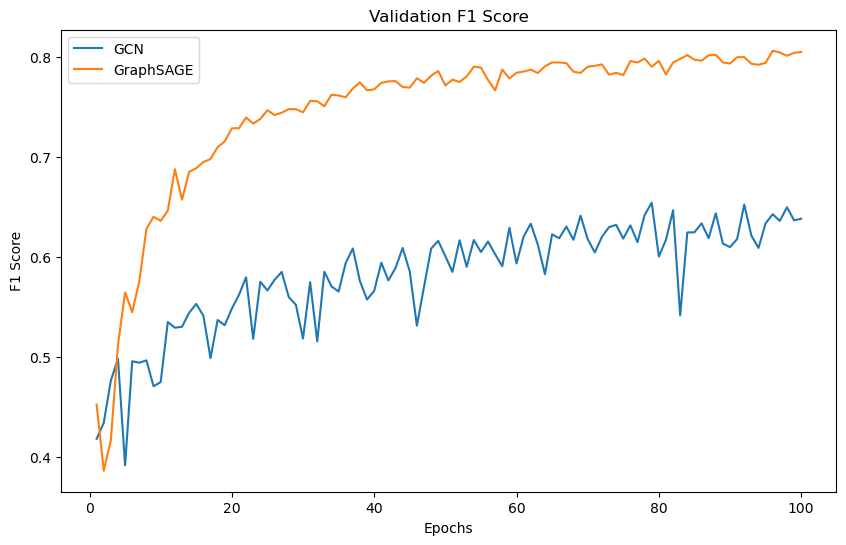

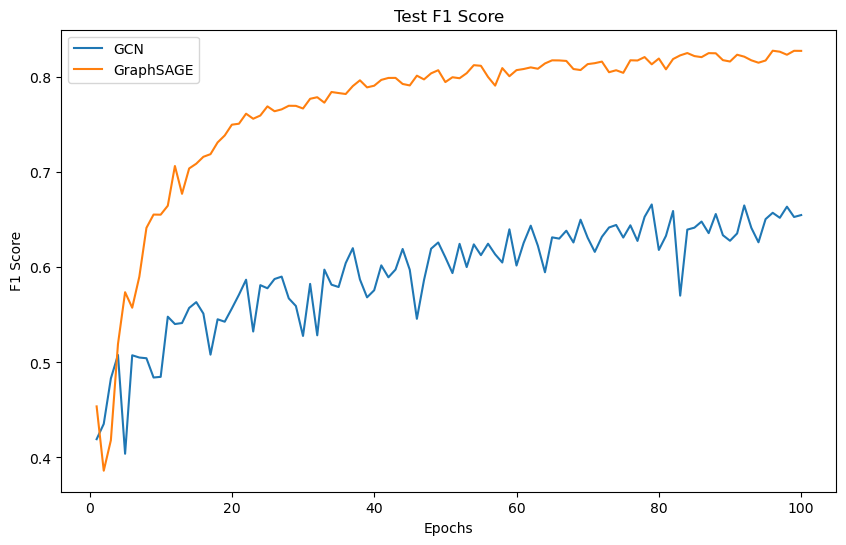

Final Test F1 Scores:
GCN: 0.6551
GraphSAGE: 0.8278


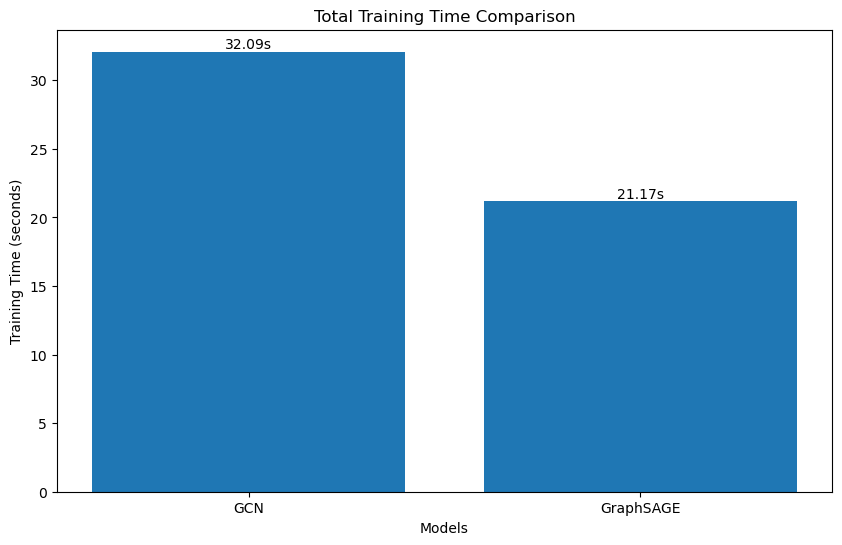


Total Training Times:
GCN: 32.09 seconds
GraphSAGE: 21.17 seconds


In [8]:
def plot_results(gcn_results, sage_results, title, ylabel):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(gcn_results) + 1)
    plt.plot(epochs, gcn_results, label='GCN')
    plt.plot(epochs, sage_results, label='GraphSAGE')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot training loss
plot_results(gcn_losses, sage_losses, 'Training Loss', 'Loss')

# Plot validation F1 score
plot_results(gcn_val_f1s, sage_val_f1s, 'Validation F1 Score', 'F1 Score')

# Plot test F1 score
plot_results(gcn_test_f1s, sage_test_f1s, 'Test F1 Score', 'F1 Score')

# Print final test F1 scores
print(f"Final Test F1 Scores:")
print(f"GCN: {gcn_test_f1s[-1]:.4f}")
print(f"GraphSAGE: {sage_test_f1s[-1]:.4f}")

# Plot training times
plt.figure(figsize=(10, 6))
models = ['GCN', 'GraphSAGE']
times = [gcn_time, sage_time]
plt.bar(models, times)
plt.title('Total Training Time Comparison')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
for i, v in enumerate(times):
    plt.text(i, v, f'{v:.2f}s', ha='center', va='bottom')
plt.show()

# Print total training times
print(f"\nTotal Training Times:")
print(f"GCN: {gcn_time:.2f} seconds")
print(f"GraphSAGE: {sage_time:.2f} seconds")


Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
Number of node features: 1433
Training GCN...
Epoch: 010, Loss: 1.8806, Train: 0.8643, Val: 0.7060, Test: 0.7190, Time: 0.0055s
Epoch: 020, Loss: 1.7570, Train: 0.9286, Val: 0.6880, Test: 0.7110, Time: 0.0054s
Epoch: 030, Loss: 1.6388, Train: 0.9429, Val: 0.7300, Test: 0.7660, Time: 0.0052s
Epoch: 040, Loss: 1.4113, Train: 0.9571, Val: 0.7660, Test: 0.7900, Time: 0.0052s
Epoch: 050, Loss: 1.2488, Train: 0.9571, Val: 0.7520, Test: 0.7800, Time: 0.0052s
Epoch: 060, Loss: 1.0889, Train: 0.9643, Val: 0.7740, Test: 0.8050, Time: 0.0051s
Epoch: 070, Loss: 0.9330, Train: 0.9786, Val: 0.7820, Test: 0.8060, Time: 0.0052s
Epoch: 080, Loss: 0.8196, Train: 0.9714, Val: 0.7660, Test: 0.8000, Time: 0.0053s
Epoch: 090, Loss: 0.7361, Train: 0.9929, Val: 0.7920, Test: 0.8100, Time: 0.0046s
Epoch: 100, Loss: 0.6728, Train: 0.9857, Val: 0.7680, Test: 0.8060, Time: 0.0049s
Epoch: 110, Loss: 0.6482, Train: 0.9929, Val: 0.7880, Test: 0.8220, 

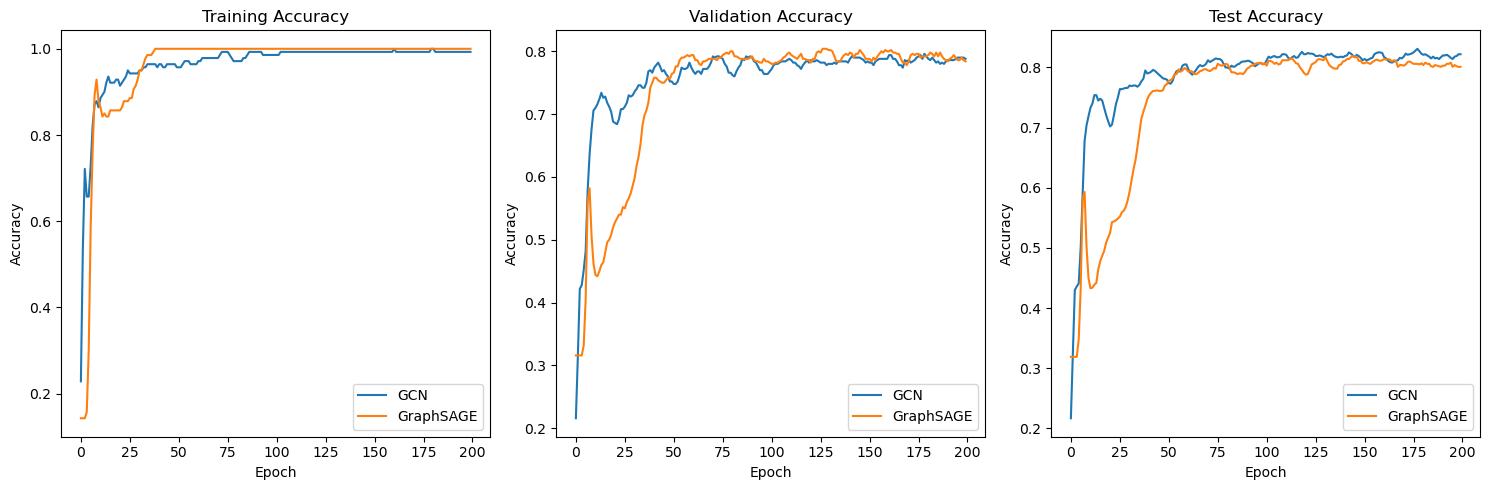


Final Test Accuracies:
GCN: 0.8270
GraphSAGE: 0.8130

Total Training Times:
GCN: 1.04 seconds
GraphSAGE: 1.71 seconds


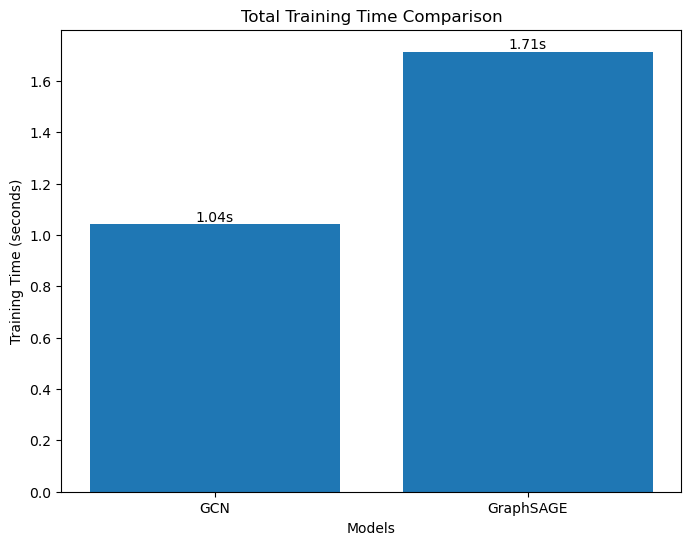

In [10]:
# GCN vs GraphSAGE Comparison on Cora Dataset (Transductive Learning)

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(50)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)

print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of node features: {dataset.num_features}")

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    val_correct = pred[data.val_mask] == data.y[data.val_mask]
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return train_acc, val_acc, test_acc

# Function to train and evaluate a model
def train_and_evaluate(model, data, optimizer, epochs=200):
    best_val_acc = 0
    final_test_acc = 0
    train_accs, val_accs, test_accs = [], [], []
    times = []
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        loss = train(model, data, optimizer)
        train_acc, val_acc, test_acc = test(model, data)
        epoch_time = time.time() - start_time
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        times.append(epoch_time)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                  f'Val: {val_acc:.4f}, Test: {test_acc:.4f}, Time: {epoch_time:.4f}s')
    
    total_time = sum(times)
    return train_accs, val_accs, test_accs, final_test_acc, total_time

# Initialize models
gcn = GCN(dataset.num_features, 16, dataset.num_classes).to(device)
sage = GraphSAGE(dataset.num_features, 16, dataset.num_classes).to(device)

# Define optimizers
gcn_optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
sage_optimizer = torch.optim.Adam(sage.parameters(), lr=0.01, weight_decay=5e-4)

# Train and evaluate models
print("Training GCN...")
gcn_train_accs, gcn_val_accs, gcn_test_accs, gcn_final_test_acc, gcn_time = train_and_evaluate(gcn, data, gcn_optimizer)

print("\nTraining GraphSAGE...")
sage_train_accs, sage_val_accs, sage_test_accs, sage_final_test_acc, sage_time = train_and_evaluate(sage, data, sage_optimizer)

# Plotting results
plt.figure(figsize=(15, 5))

# Training Accuracy
plt.subplot(131)
plt.plot(gcn_train_accs, label='GCN')
plt.plot(sage_train_accs, label='GraphSAGE')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Validation Accuracy
plt.subplot(132)
plt.plot(gcn_val_accs, label='GCN')
plt.plot(sage_val_accs, label='GraphSAGE')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Test Accuracy
plt.subplot(133)
plt.plot(gcn_test_accs, label='GCN')
plt.plot(sage_test_accs, label='GraphSAGE')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Test Accuracies:")
print(f"GCN: {gcn_final_test_acc:.4f}")
print(f"GraphSAGE: {sage_final_test_acc:.4f}")

print("\nTotal Training Times:")
print(f"GCN: {gcn_time:.2f} seconds")
print(f"GraphSAGE: {sage_time:.2f} seconds")

# Plot training times
plt.figure(figsize=(8, 6))
models = ['GCN', 'GraphSAGE']
times = [gcn_time, sage_time]
plt.bar(models, times)
plt.title('Total Training Time Comparison')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
for i, v in enumerate(times):
    plt.text(i, v, f'{v:.2f}s', ha='center', va='bottom')
plt.show()
